# Self-supervised Semantic Segmentation: Consistency over Transformation

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T

import cv2
import sys
import os
import numpy as np
import random
import glob
from matplotlib import pyplot as plt

from utils import dice_metric, xor_metric, hm_metric, create_mask
from utils import read_image, compute_sobel_gradients
from model_utils import AttentionModule, DeformableConv, LearnableAffineTransform

In [2]:
use_cuda = torch.cuda.is_available()

parser = argparse.ArgumentParser(description='Self-supervised Semantic Segmentation: Consistency over Transformation')
parser.add_argument('--nChannel', metavar='N', default=64, type=int, 
                    help='number of channels')
parser.add_argument('--maxIter', metavar='T', default=50, type=int, 
                    help='number of maximum iterations')
parser.add_argument('--minLabels', metavar='minL', default=3, type=int, 
                    help='minimum number of labels')
parser.add_argument('--lr', metavar='LR', default=0.2, type=float, 
                    help='learning rate')
parser.add_argument('--nConv', metavar='M', default=2, type=int, 
                    help='number of convolutional layers')
parser.add_argument('--input_path', metavar='INPUT', default='./input_images/image/', 
                    help='input image folder path')
parser.add_argument('--save_output', metavar='SAVE', default=True, 
                    help='whether to save output ot not')
parser.add_argument('--output_path', metavar='OUTPUT', default='./results/', 
                    help='output folder path')

parser.add_argument('--loss_ce_coef', metavar='CE', default=3.5, type=float, 
                    help='Cross entropy loss weighting factor')
parser.add_argument('--loss_at_coef', metavar='AT', default=0.5, type=float, 
                    help='Affine transformation loss weighting factor')
parser.add_argument('--loss_b_coef', metavar='B', default=2, type=float, 
                    help='Boundary loss weighting factor')

parser.add_argument('--color', default=False, type=bool, 
                    help='Whether to use color information duriring training: GOOD for binary segmentation')

args = parser.parse_args(args=[])

In [3]:
if args.save_output:
    SAVE_PATH = args.output_path
    os.makedirs(SAVE_PATH, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data

In [4]:
IMG_PATH = args.input_path
img_data = sorted(glob.glob(IMG_PATH + '*'))

In [5]:
len(img_data)

5

In [6]:
5

5

# Model

In [7]:
class S3Net(nn.Module):
    def __init__(self, in_channels, nChannel, nConv, BHW=(1, 256, 256), color=False, beta=16):
        """
        Initialize the S^3Net model.

        :param in_channels: Number of input channels.
        :param nChannel: Number of output channels.
        :param nConv: Number of convolutional layers.
        :param BHW: (Batch size, Height of the input image, Width of the input image).
        :param color: Flag to indicate whether to use color processing (good for binary segmentation).
        :type in_channels: int
        :type nChannel: int
        :type nConv: int
        :type BHW: tuple (int, int, int)
        :type color: bool
        """
        super(S3Net, self).__init__()
        
        self.color = color
        self.beta = 16 #Downsampling factor
        
        # Initial Convolution Layer
        self.conv1 = nn.Conv2d(in_channels, nChannel, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(nChannel)

        # Attention Convolution Layers
        self.conv2 = nn.ModuleList([AttentionModule(nChannel) for _ in range(nConv)])
        self.bn2 = nn.ModuleList([nn.BatchNorm2d(nChannel) for _ in range(nConv)])

         # Deformable Convolution Layer
        self.convdeform = DeformableConv(nChannel, batch=BHW[0], height=BHW[1], width=BHW[2])
        self.bn3 = nn.BatchNorm2d(nChannel)

        # Additional Convolution Layer
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(nChannel)
        
        # Auxiliary Convolution for the Affine Transformation Branch
        self.conv_aux = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0)
        self.bn_aux = nn.BatchNorm2d(nChannel)

        if self.color:
            # Linear Mapping for Color Processing
            self.map = nn.Linear(3, nChannel, bias=False)
            self.cf = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0)
            self.bf = nn.BatchNorm2d(nChannel)

            
    def forward(self, x):
        inp = x.clone()
        
        # Initial Convolution
        x = self.bn1(self.conv1(x))
        
        # Attention Convolution Blocks
        for i in range(len(self.conv2)):
            x = self.bn2[i](self.conv2[i](x))
        
        # Auxiliary Convolution for the Affine Transformation Branch
        x_aux = self.bn_aux(self.conv_aux(x))
        
        # Deformable Convolution
        x = self.bn3(self.convdeform(x))
        
        # Additional Convolution Layer
        x = self.bn4(self.conv3(x))
        
        
        

        if self.color:
            # Color Processing
            x1 = x.view(x.size(0), x.size(1), -1)
            x1 = F.normalize(x1, dim=-1)
            x1 = torch.matmul(x1, F.softmax(x1.transpose(-2, -1)))

            inp = inp.view(inp.size(0), inp.size(1), -1)
            inp = self.map(inp.permute(0, 2, 1)).permute(0, 2, 1)

            inp = F.normalize(inp, dim=-1)
            inp = torch.matmul(inp, F.softmax(inp.transpose(-2, -1)))
            att = inp + x1

            v = x.view(x.size(0), x.size(1), -1)
            xatt = torch.matmul(att, v)
            xatt = xatt.view(x.size(0), x.size(1), x.size(2), x.size(3))
            x = self.bf(self.cf(xatt))
        # D-U
        _, edge1 = torch.max(x, 1)
        Bx_down = torchvision.transforms.functional.resize(x, 256//self.beta, antialias=True)
        Bx_up = torchvision.transforms.functional.resize(Bx_down, 256, antialias=True)
        _, edge2 = torch.max(Bx_up, 1)
        edge = edge1 - edge2
        # Affine Transformation 
        random_affine_transform = T.RandomAffine(
        degrees=(-90, 90),  # 随机旋转角度范围
        translate=(0.1, 0.1),  # 平移比例范围
        scale=(0.9, 1.1),  # 缩放比例范围
        shear=(-10, 10),  # 剪切范围
        )

        # 应用变换到图像上
        LA = LearnableAffineTransform()
        x_aux = LA(x_aux)
        #x_aux = torchvision.transforms.functional.affine(x_aux, angle=90, translate=(0, 0),
                                                               #scale=1.0, shear=0.0)

        return x, x_aux, edge

# Training

In [8]:
img_size = 256

###for img_num, img_file in enumerate(img_data):
    
    ##### Read image #####
    image = read_image(img_file, img_size).to(device)

    ##### Laod Model #####
    model = S3Net(in_channels=image.size(1), nChannel=args.nChannel, nConv=args.nConv,
                  BHW=(image.size(0), img_size, img_size), color=args.color).to(device)
    model.train()

    ##### Setteings #####
    zero_img = torch.zeros(image.shape[2], image.shape[3]).to(device)
    
    loss_ce = torch.nn.CrossEntropyLoss()
    loss_s = torch.nn.L1Loss()
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    label_colours = np.random.randint(255, size=(100, 3))
    
    
    ##### Training #####
    for batch_idx in range(args.maxIter):

        optimizer.zero_grad()
        output, out_auxi, edge = model(image)
                
        
        ### Output
        output, out_auxi = output[0], out_auxi[0]
        msk_auxi = torchvision.transforms.functional.affine(output, angle = 90, translate=(0, 0), scale=1.0, shear=0.0)
        output = output.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
        
        _, target = torch.max(output, 1)
        img_target = target.data.cpu().numpy()
        img_target_rgb = np.array([label_colours[c % args.nChannel] for c in img_target])
        img_target_rgb = img_target_rgb.reshape(image.shape[2], image.shape[3], image.shape[1]).astype(np.uint8)
        
        
        ### Cross-entropy loss function         
        loss_ce_value = args.loss_ce_coef * loss_ce(output, target)
        
        
        ### Affine transform loss function

        msk_auxi = msk_auxi.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
        _, target_auxi = torch.max(msk_auxi, 1)
        gt_auxi = out_auxi.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
        
        loss_at_value = args.loss_at_coef * loss_ce(gt_auxi, target_auxi)
        ### Boundary Loss
        loss_edge = args.loss_b_coef * loss_s(edge[0], zero_img)
        

        ### Spatial loss function 
        # Calculate sobel for the spatial loss fucntion
        #sub_y_x, sub_xy_x, sub_xy_y = compute_sobel_gradients(img_target_rgb)
        
        #loss_y_x = loss_s(sub_y_x, zero_img)
        #loss_xy_x = loss_s(sub_xy_x, zero_img)
        #loss_xy_y = loss_s(sub_xy_y, zero_img)
        
        #loss_s_value = args.loss_s_coef * (loss_y_x + loss_xy_x + loss_xy_y)

        
        ### Optimization
        loss = loss_ce_value + loss_at_value + loss_edge
        loss.backward()
        optimizer.step()
        
        
        nLabels = len(np.unique(img_target))
        print(batch_idx, '/', args.maxIter, '|', ' label num:', nLabels, ' | loss:', round(loss.item(), 4),
                '| CE:', round(loss_ce_value.item(), 4), '| AT:', round(loss_at_value.item(), 4),
                '| B:', round(loss_edge.item(), 4))
            
        if nLabels <= args.minLabels and batch_idx>=5:
            print (f"Number of labels have reached {nLabels}")
            break
            


    ##### Evaluate #####
    output, _, edge = model(image)
    output = output[0].permute(1, 2, 0).contiguous().view(-1, args.nChannel)
    _, target = torch.max(output, 1)
    img_target = target.data.cpu().numpy()
    img_eval_output = np.array([label_colours[c % args.nChannel] for c in img_target])
    img_eval_output = img_eval_output.reshape(image.shape[2], image.shape[3], image.shape[1]).astype(np.uint8)
    
    
    ##### Visualization #####
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(img_eval_output)
    axes[1].imshow(image[0].permute(1, 2, 0).cpu().detach().numpy()[..., ::-1])
    axes[0].set_title('Prediction')
    axes[1].set_title('Input Image')
    axes[0].axis('off')
    axes[1].axis('off')
    plt.show()
    
    if args.save_output:
        name = os.path.basename(img_file).split('.')[0]
        cv2.imwrite(SAVE_PATH + '/S3_mask_' + name + '.png', img_eval_output)
        
    print('-------------------------------', '\n')

0 / 50 |  label num: 61  | loss: 51.3825 | CE: 10.9437 | AT: 2.3171 | B: 38.1216
1 / 50 |  label num: 51  | loss: 41.2129 | CE: 11.8775 | AT: 2.25 | B: 27.0854
2 / 50 |  label num: 47  | loss: 36.4249 | CE: 11.0749 | AT: 2.3299 | B: 23.0201
3 / 50 |  label num: 47  | loss: 40.8954 | CE: 9.9805 | AT: 2.2755 | B: 28.6395
4 / 50 |  label num: 40  | loss: 30.5289 | CE: 9.7034 | AT: 2.2066 | B: 18.619
5 / 50 |  label num: 13  | loss: 11.4375 | CE: 7.2821 | AT: 2.2499 | B: 1.9054
6 / 50 |  label num: 3  | loss: 9.1719 | CE: 4.7167 | AT: 2.1335 | B: 2.3217
Number of labels have reached 3


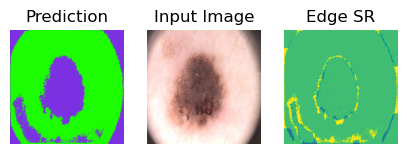

------------------------------- 

0 / 50 |  label num: 64  | loss: 48.7334 | CE: 10.4015 | AT: 2.2894 | B: 36.0424
1 / 50 |  label num: 51  | loss: 54.4068 | CE: 11.6186 | AT: 2.3145 | B: 40.4737


In [ ]:
for img_num, img_file in enumerate(img_data):
    ##### Read image #####
    image = read_image(img_file, img_size).to(device)

    ##### Laod Model #####
    model = S3Net(in_channels=image.size(1), nChannel=args.nChannel, nConv=args.nConv,
                  BHW=(image.size(0), img_size, img_size), color=args.color).to(device)
    model.train()

    ##### Setteings #####
    zero_img = torch.zeros(image.shape[2], image.shape[3]).to(device)
    
    loss_ce = torch.nn.CrossEntropyLoss()
    loss_s = torch.nn.L1Loss()
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    label_colours = np.random.randint(255, size=(100, 3))
    ##### Training #####
    for batch_idx in range(args.maxIter):

        optimizer.zero_grad()
        output, out_auxi, edge = model(image)
       
        
        ### Output
        output, out_auxi = output[0], out_auxi[0]
        msk_auxi = torchvision.transforms.functional.affine(output, angle = 90, translate=(0, 0), scale=1.0, shear=0.0)
        output = output.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
        
        _, target = torch.max(output, 1)
        img_target = target.data.cpu().numpy()
        img_target_rgb = np.array([label_colours[c % args.nChannel] for c in img_target])
        img_target_rgb = img_target_rgb.reshape(image.shape[2], image.shape[3], image.shape[1]).astype(np.uint8)
        
        
        ### Cross-entropy loss function         
        loss_ce_value = args.loss_ce_coef * loss_ce(output, target)
        
        ### AT loss
        msk_auxi = msk_auxi.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
        _, target_auxi = torch.max(msk_auxi, 1)
        gt_auxi = out_auxi.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
        
        loss_at_value = args.loss_at_coef * loss_ce(gt_auxi, target_auxi)
        ### Boundary Loss
        loss_edge = args.loss_b_coef * loss_s(edge[0], zero_img)
        

        ### Spatial loss function 
        # Calculate sobel for the spatial loss fucntion
        #sub_y_x, sub_xy_x, sub_xy_y = compute_sobel_gradients(img_target_rgb)
        
        #loss_y_x = loss_s(sub_y_x, zero_img)
        #loss_xy_x = loss_s(sub_xy_x, zero_img)
        #loss_xy_y = loss_s(sub_xy_y, zero_img)
        
        #loss_s_value = args.loss_s_coef * (loss_y_x + loss_xy_x + loss_xy_y)

        
        ### Optimization
        loss = loss_ce_value + loss_at_value + loss_edge
        loss.backward()
        optimizer.step()
        
        
        nLabels = len(np.unique(img_target))
        print(batch_idx, '/', args.maxIter, '|', ' label num:', nLabels, ' | loss:', round(loss.item(), 4),
                '| CE:', round(loss_ce_value.item(), 4), '| AT:', round(loss_at_value.item(), 4),
                '| B:', round(loss_edge.item(), 4))
            
        if nLabels <= args.minLabels and batch_idx>=5:
            print (f"Number of labels have reached {nLabels}")
            break
    ##### Evaluate #####
    output, _, edge = model(image)
    output = output[0].permute(1, 2, 0).contiguous().view(-1, args.nChannel)
    _, target = torch.max(output, 1)
    img_target = target.data.cpu().numpy()
    img_eval_output = np.array([label_colours[c % args.nChannel] for c in img_target])
    img_eval_output = img_eval_output.reshape(image.shape[2], image.shape[3], image.shape[1]).astype(np.uint8)
    
    
    ##### Visualization #####
    fig, axes = plt.subplots(1, 3, figsize=(5, 5))
    axes[0].imshow(img_eval_output)
    axes[1].imshow(image[0].permute(1, 2, 0).cpu().detach().numpy()[..., ::-1])
    axes[2].imshow(edge[0].cpu().detach().numpy())
    axes[0].set_title('Prediction')
    axes[1].set_title('Input Image')
    axes[2].set_title('Edge SR')   
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    plt.show()
    
    if args.save_output:
        name = os.path.basename(img_file).split('.')[0]
        cv2.imwrite(SAVE_PATH + '/S3_mask_' + name + '.png', img_eval_output)
        
    print('-------------------------------', '\n')